In [1]:
import pandas as pd
from datetime import datetime, timedelta
from gmma import mixture
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Configs  

In [2]:
dt = 0.01
vp = 6.0
vs = vp/1.75
dims = ['x(km)', 'y(km)', 'z(km)']
bounds = ((-1, 111),(-1, 111),(0, 20), (None, None))
use_amplitude = True
dbscan_eps = 111/(6.0/1.75)/2
dbscan_min_samples = int(16 * 0.8)
min_picks_per_eq = int(16 * 0.6)
oversample_factor = 5.0
verbose = 1

## Read picks 

In [17]:
stations = pd.read_csv("stations.csv", delimiter="\t", index_col="station")
events = pd.read_csv("events.csv", delimiter="\t")
num_sta, num_evt = len(stations), len(events)
print(f"Number of stations: {num_sta}")
print(f"Number of events in catalog: {num_evt}")

Number of stations: 16
Number of events in catalog: 1062


In [16]:
# picks = pd.read_csv("../PhaseNet/phasenet/results/picks.csv", sep="\t")
picks = pd.read_csv("picks.csv", sep="\t")
picks["time"] = picks["fname"].map(lambda x: x.split(".")[0])
picks["station"] = picks["fname"].map(lambda x: ".".join(x.split(".")[1:]))
picks["idx_p"] = picks["idx_p"].map(lambda x: [round(float(i)*dt, 2) for i in x.strip("[]").split(",") if i != ""])
picks["idx_s"] = picks["idx_s"].map(lambda x: [round(float(i)*dt, 2) for i in x.strip("[]").split(",") if i != ""])
picks["prob_p"] = picks["prob_p"].map(lambda x: [round(float(i), 2) for i in x.strip("[]").split(",") if i != ""])
picks["prob_s"] = picks["prob_s"].map(lambda x: [round(float(i), 2) for i in x.strip("[]").split(",") if i != ""])
if use_amplitude:
    picks["amp_p"] = picks["amp_p"].map(lambda x: [float(i) for i in x.strip("[]").split(",") if i != ""])
    picks["amp_s"] = picks["amp_s"].map(lambda x: [float(i) for i in x.strip("[]").split(",") if i != ""])

In [5]:
meta = pd.merge(stations, picks, on="station")
time_intervals = sorted(list(set(meta["time"])))

## Visulization

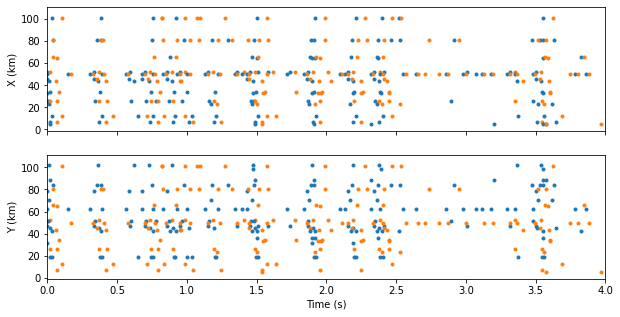

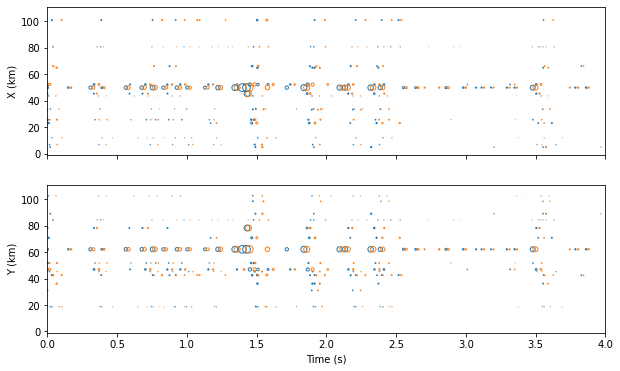

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
# for i in range(len(picks["idx_p"])):
for i in range(len(stations)):
    plt.plot(np.array(picks["idx_p"][i])*dt, np.ones_like(picks["idx_p"][i])*stations.loc[picks["station"][i]]["x(km)"], 'C0.')
    plt.plot(np.array(picks["idx_s"][i])*dt, np.ones_like(picks["idx_s"][i])*stations.loc[picks["station"][i]]["x(km)"], 'C1.')
plt.xlim([0, 4])
plt.gca().set_xticklabels("")
plt.ylim(bounds[0])
plt.ylabel("X (km)")
plt.subplot(2,1,2)
# for i in range(len(picks["idx_p"])):
for i in range(len(stations)):
    plt.plot(np.array(picks["idx_p"][i])*dt, np.ones_like(picks["idx_p"][i])*stations.loc[picks["station"][i]]["y(km)"], 'C0.')
    plt.plot(np.array(picks["idx_s"][i])*dt, np.ones_like(picks["idx_s"][i])*stations.loc[picks["station"][i]]["x(km)"], 'C1.')
plt.xlim([0, 4])
plt.ylim(bounds[1])
plt.xlabel("Time (s)")
plt.ylabel("Y (km)")

if use_amplitude:
    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
#     for i in range(len(picks["idx_p"])):
    for i in range(len(stations)):
        plt.scatter(np.array(picks["idx_p"][i])*dt, np.ones_like(picks["idx_p"][i])*stations.loc[picks["station"][i]]["x(km)"], s=(np.array(picks["amp_p"][i]))*5e4, edgecolors='C0', facecolors='none')
        plt.scatter(np.array(picks["idx_s"][i])*dt, np.ones_like(picks["idx_s"][i])*stations.loc[picks["station"][i]]["x(km)"], s=(np.array(picks["amp_s"][i]))*5e4, edgecolors='C1', facecolors='none')
    plt.xlim([0, 4])
    plt.gca().set_xticklabels("")
    plt.ylabel("X (km)")
    plt.ylim(bounds[0])
    plt.subplot(2,1,2)
#     for i in range(len(picks["idx_p"])):
    for i in range(len(stations)):
        plt.scatter(np.array(picks["idx_p"][i])*dt, np.ones_like(picks["idx_p"][i])*stations.loc[picks["station"][i]]["y(km)"], s=(np.array(picks["amp_p"][i]))*5e4, edgecolors='C0', facecolors='none')
        plt.scatter(np.array(picks["idx_s"][i])*dt, np.ones_like(picks["idx_s"][i])*stations.loc[picks["station"][i]]["y(km)"], s=(np.array(picks["amp_s"][i]))*5e4, edgecolors='C1', facecolors='none')
    plt.xlim([0, 4])
    plt.xlabel("Time (s)")
    plt.ylabel("Y (km)")
    plt.ylim(bounds[1])

In [7]:
def convert_data(meta, dims):
    data = []
    locs = []
    phase_type = []
    phase_weight = []
    for i in range(len(meta)):
        for j in range(len(meta.iloc[i]["idx_p"])):
            if use_amplitude:
                data.append([meta.iloc[i]["idx_p"][j], np.log10(meta.iloc[i]["amp_p"][j]*1e2)])
            else:
                data.append([meta.iloc[i]["idx_p"][j]])
            locs.append(meta.iloc[i][dims].values.astype("float"))
            phase_type.append("p")
            phase_weight.append(meta.iloc[i]["prob_p"][j])
        for j in range(len(meta.iloc[i]["idx_s"])):
            if use_amplitude:
                data.append([meta.iloc[i]["idx_s"][j], np.log10(meta.iloc[i]["amp_s"][j]*1e2)])
            else:
                data.append([meta.iloc[i]["idx_s"][j]])
            locs.append(meta.iloc[i][dims].values.astype("float"))
            phase_type.append("s")
            phase_weight.append(meta.iloc[i]["prob_s"][j])
    locs = np.array(locs)
    data = np.array(data)
    phase_weight = np.array(phase_weight)[:, np.newaxis]
    return data, locs, phase_type, phase_weight

In [8]:
def plot_assoc(t_pick, loc_pick, eq_center, eq_idx, pred, dims, bounds, t0, t_range, dt=0.01):
    
    plt.figure(figsize=(t_range/25, 3))

    plt.plot((t_pick[:,0]-t0)*dt, loc_pick[:,1], 'o', markeredgecolor="gray", markerfacecolor='none', markersize=4)

    for i, idx in enumerate(eq_idx):
#         plt.scatter((t_pick[(pred==idx), 0]-t0)*dt, loc_pick[(pred==idx), 1], s=20, c=f'C{i}')
        plt.plot((t_pick[pred==idx,0]-t0)*dt, loc_pick[pred==idx,1], 'o', color=f'C{i}', markersize=4)
        plt.plot((eq_center[idx, len(dims)]-t0)*dt, eq_center[idx, 1], 'P', color=f"C{i}", markeredgecolor="black", markersize=12)

    plt.xlim(-0.1, t_range*dt+0.1)
    plt.ylim(bounds[1])
    plt.ylabel("Y (km)")
    plt.xlabel("Time (s)")
    plt.savefig(f"figures/{t0}.png", bbox_inches="tight", dpi=300)
    plt.savefig(f"figures/{t0}.pdf", bbox_inches="tight")
    plt.show()

In [9]:
eq_time = []
eq_loc = []
eq_mag = []
eq_std = []

num = 0
for t in tqdm(time_intervals):
    
    data, locs, phase_type, phase_weight = convert_data(meta[meta["time"] == t], dims)

    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(data)
    labels = db.labels_
    unique_labels = set(labels)

    for k in unique_labels:
        if k == -1:
            continue

        class_mask = (labels == k)
        data_ = data[class_mask]
        locs_ = locs[class_mask]
        phase_type_ = np.array(phase_type)[class_mask]
        phase_weight_ = phase_weight[class_mask]

        num_event_ = min(max(int(len(data_)/num_sta*oversample_factor), 1), len(data_))
        t0 = data_[:,0].min()
        t_range = max(data_[:,0].max() - data_[:,0].min(), 1)
        centers_init = np.vstack([np.ones(num_event_)*np.mean(stations["x(km)"]),
                                  np.ones(num_event_)*np.mean(stations["y(km)"]),
                                  np.zeros(num_event_),
                                  np.linspace(data_[:,0].min()-0.1*t_range, data_[:,0].max()+0.1*t_range, num_event_)]).T # n_eve, n_dim(x, y, z) + 1(t)
        
        # dummy_prob = 1/((2*np.pi)**(data.shape[-1]/2) * 50)
#         dummy_prob = 1/(50)
#         gmm = mixture.GaussianMixture(n_components=num_event_, 
#                                       init_params="centers",
#                                       centers_init=centers_init, 
#                                       station_locs=locs_, 
#                                       phase_type=phase_type_, 
#                                       phase_weight=phase_weight_,
#                                       loss_type="l1",
#                                       bounds=bounds,
#                                       max_covar=10,
#                                       reg_covar=0.1,
#                                      ).fit(data_) 


        if use_amplitude:
            covariance_prior = np.array([[1,0],[0,1]]) * 3
        else:
            covariance_prior = np.array([[1]])
        gmm = mixture.BayesianGaussianMixture(n_components=num_event_, 
                                              weight_concentration_prior=1000/num_event_,
                                              mean_precision_prior = 0.3/t_range,
                                              covariance_prior = covariance_prior,
                                              init_params="centers",
                                              centers_init=centers_init, 
                                              station_locs=locs_, 
                                              phase_type=phase_type_, 
                                              phase_weight=phase_weight_,
                                              loss_type="l1",
                                              bounds=bounds,
                                              max_covar=10.0,
                                              reg_covar=0.1,
                                              ).fit(data_) 
        
        pred = gmm.predict(data_) 
        prob = gmm.predict_proba(data_)
        prob_eq = prob.mean(axis=0)
        std_eq = gmm.covariances_[:,...]
        prob_data = prob[range(len(data_)), pred]
        score_data = gmm.score_samples(data_)

        idx = np.array([True if len(data_[pred==i, 0]) >= max(num_sta*0.6, 4) else False for i in range(len(prob_eq))]) #& (prob_eq > 1/num_event) #& (std_eq[:, 0,0] < 40)
        eq_idx = np.arange(len(idx))[idx]

        time = pd.Timestamp(t) + gmm.centers_[idx, len(dims)].astype('timedelta64[s]')
        loc = gmm.centers_[idx, :len(dims)]
        if use_amplitude:
            mag = gmm.centers_[idx, len(dims)+1]

        eq_time.append(time)
        eq_loc.append(loc)
        if use_amplitude:
            eq_mag.append(mag)
        eq_std.append(std_eq[idx])
        
#         print(std_eq[idx])
#         if verbose == 1:
#             plot_assoc(data_, locs_, gmm.centers_, eq_idx, pred, dims, bounds, t0, t_range)
#         if len(std_eq[idx]) > 0:
#             if np.max(std_eq[idx]) > 10:
#                 plot_assoc(data_, locs_, gmm.centers_, eq_idx, pred, dims, bounds, t0, t_range)

    num += 1


 10%|█         | 5/48 [02:24<21:20, 29.77s/it]/Users/weiqiang/Research/Project-GMMA/scikit-learn/gmma/mixture/_base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 12%|█▎        | 6/48 [02:51<20:19, 29.03s/it]/Users/weiqiang/Research/Project-GMMA/scikit-learn/gmma/mixture/_base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 15%|█▍        | 7/48 [03:13<18:17, 26.78s/it]/Users/weiqiang/Research/Project-GMMA/scikit-learn/gmma/mixture/_base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
 33%|███▎      | 16/48 [05:30<06:41, 

In [10]:
eq_time = np.hstack(eq_time)
if use_amplitude:
    eq_mag = np.hstack(eq_mag)
eq_loc = np.vstack(eq_loc)
if use_amplitude:
    eq_std = np.vstack(eq_std)
else:
    eq_std = np.hstack(eq_std)
# eq_prob = np.hstack(eq_prob)
# data_prob = np.hstack(data_prob)
# data_score = np.hstack(data_score)
catalog = {}
catalog["time"] = eq_time
if use_amplitude:
    catalog["mag"] = eq_mag
for i, k in enumerate(dims):
    catalog[k] = eq_loc[:,i]
# catalog["prob"] = eq_prob
# if use_amplitude:
#     catalog["std"] = eq_std[:,0,0]
# else:
if use_amplitude:
    catalog["std"] = np.sqrt(eq_std[:,0,0])
else:
    catalog["std"] = np.sqrt(eq_std)
if use_amplitude:
    catalog = pd.DataFrame(catalog, columns=["time", "mag"]+dims+["std"])
else:
    catalog = pd.DataFrame(catalog, columns=["time"]+dims+["std"])

In [11]:
c = catalog

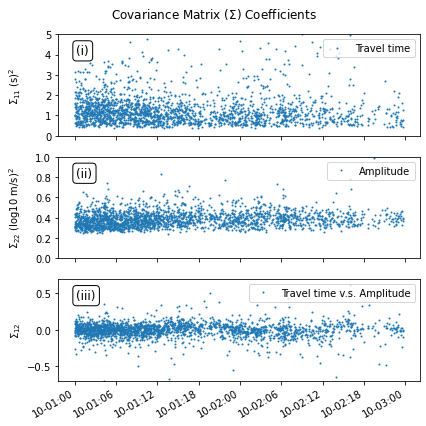

In [12]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1,1.5]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(c["time"], eq_std[:,0,0], '.', markersize=2.0, label="Travel time")
plt.ylim([0, 5])
plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(c["time"], eq_std[:,1,1], '.', markersize=2.0, label=r"Amplitude")
plt.ylim([0, 1])
plt.ylabel(r"$\Sigma_{22}$ ($\log10$ m/s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(c["time"], eq_std[:,0,1], '.', markersize=2.0, label="Travel time v.s. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.7, 0.7])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig("covariance.png", bbox_inches="tight", dpi=300)
plt.savefig("covariance.pdf", bbox_inches="tight")


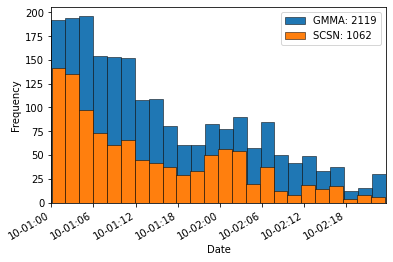

In [13]:
plt.figure()
plt.hist(c["time"], bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"GMMA: {len(c['mag'])}")
plt.hist(events["time"], bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"SCSN: {len(events['mag'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig("eq_numbers.png", bbox_inches="tight", dpi=300)
plt.savefig("eq_numbers.pdf", bbox_inches="tight")
plt.show()

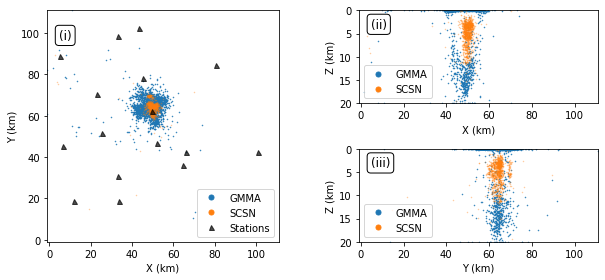

In [14]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5,1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(c["x(km)"], c["y(km)"], '.',markersize=1, alpha=1.0)
plt.plot(events["x(km)"], events["y(km)"], '.', markersize=1, alpha=0.4)
plt.axis("scaled")
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.gca().set_prop_cycle(None)
plt.plot(-10, -10, '.', markersize=10, label=f"GMMA")
plt.plot(-10, -10, '.', markersize=10, label=f"SCSN")
plt.plot(stations["x(km)"], stations["y(km)"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(c["x(km)"], c["z(km)"], '.', markersize=1, alpha=1.0)
plt.plot(events["x(km)"], events["z(km)"], '.', markersize=1, alpha=0.4)
# plt.axis("scaled")
plt.xlim(bounds[0])
plt.ylim(bounds[2])
plt.gca().invert_yaxis()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.gca().set_prop_cycle(None)
plt.plot(-1, -1, '.', markersize=10, label=f"GMMA")
plt.plot(-1, -1, '.', markersize=10, label=f"SCSN")
plt.legend(loc="lower left")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(c["y(km)"], c["z(km)"], '.', markersize=1, alpha=1.0)
plt.plot(events["y(km)"], events["z(km)"], '.', markersize=1, alpha=0.4)
# plt.axis("scaled")
plt.xlim(bounds[1])
plt.ylim(bounds[2])
plt.gca().invert_yaxis()
plt.xlabel("Y (km)")
plt.ylabel("Z (km)")
plt.gca().set_prop_cycle(None)
plt.plot(-1, -1, '.', markersize=10, label=f"GMMA")
plt.plot(-1, -1, '.', markersize=10, label=f"SCSN")
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig("location.png", bbox_inches="tight", dpi=300)
plt.savefig("location.pdf", bbox_inches="tight")
plt.show()

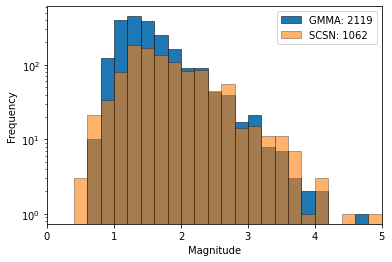

In [15]:
plt.figure()
plt.hist(c["mag"], range=(0.,5.), bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"GMMA: {len(c['mag'])}")
plt.hist(events["mag"], range=(0.,5.), bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"SCSN: {len(events['mag'])}")
plt.legend()
# plt.figure()
plt.xlim([0,5])
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.gca().set_yscale('log')
plt.savefig("mag_freq.png", bbox_inches="tight", dpi=300)
plt.savefig("mag_freq.pdf", bbox_inches="tight")
plt.show()